Using 1D Convolutional layers to process sequences:
- 1D Conv layers can slide several kernels across a sequence, producing a 1D feature map per kernel. Each kernel learns to detect a very short squential pattern (no longer than the kernel size). Using 10 kernels results in layer's output composed of 10 1D sequences (all of the same length). This means you can build a neural network composed of a mix of recurrent layers and 1D conv layers . 
- Below, a model is built starting with a 1D conv layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride so all inputs will be used to compute the layer's output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences the conv layer may help the rnn detect longer patterns, so we can afford to double the input sequence to 112 days
- Note: We must also crop off the first 3 timesteps in the targets: indeed the kernel's size is 4, so the first output of the conv layer is based off the input timesteps (0 to 3), and the first forecasts wull be for timesteps 4 to 17 (instead of 1 to 14). Moreover, we must downsample the targets by a factor of 2 because of the stride:

Building this model out:

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from utils.fetch_data import fetch_timeseries_data
from utils.early_stopping import EarlyStopping
from utils.fetch_data import create_splits

In [2]:
torch.manual_seed(1)

Get the data:

In [3]:
df = fetch_timeseries_data()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [4]:
df.shape

(9009, 3)

Already explored this in notebook 13 and 14 - so proceed now to fetch the train, validation, and test splits -  for the rail data as this task is a univariate timeseries forecasting task.

In [5]:
rail_train, rail_valid, rail_test = create_splits(df, attr='rail', train_ran=['2014-01','2023-12'],val_ran=['2024-01','2024-12'],test_ran=['2025-01'])

Creating chunks now - considering the fact that the first layer will be a 1D Conv layer, with a kernel size of 4 and stride of 2. Meaning right off the based off the nature of the kernel size, we aren't processing a single item in a sequence at a time but rather 4 items at a time and hence the targets need to start after skipping the first 4 items. Also, because of the stride of 2 - the targets need to get offset by 2 (skipping 1 before taking the next target batch).

since we shall be using a convnet, we can afford to double the input sequence length from 56 to 112, as the convnet will still break this down to kernels of length 56. 

In [6]:
seq_length = 112
forecasting_horizon = 14
strides = 2
kernel_size=4

def create_x_chunks(ds):
    return [ds[i:i+seq_length] for i in range(len(ds)-seq_length-forecasting_horizon-strides+1)]

In [9]:
def create_y_chunks2(ds):
    y_chunks = []
    conv_seq_len = (seq_length - kernel_size) // 2 + 1   # 55

    for i in range(len(ds)-seq_length-forecasting_horizon-strides+1):
        seq_chunk = []
        for j in range(conv_seq_len):
            start = i + kernel_size + j*strides # i + kernel size so as to start picking targets up from where the training kernel has stopped, j*strides to ensure we skip over as t
            end   = start + forecasting_horizon
            seq_chunk.append(ds[start:end])
        y_chunks.append(seq_chunk)

    return y_chunks

In [10]:
train_x_chunks, train_y_chunks = create_x_chunks(rail_train.values.tolist()), create_y_chunks2(rail_train.values.tolist())
valid_x_chunks, valid_y_chunks = create_x_chunks(rail_valid.values.tolist()), create_y_chunks2(rail_valid.values.tolist())
test_x_chunks, test_y_chunks = create_x_chunks(rail_test.values.tolist()), create_y_chunks2(rail_test.values.tolist())

In [11]:
train_x_chunks, train_y_chunks = torch.tensor(train_x_chunks), torch.tensor(train_y_chunks)
valid_x_chunks, valid_y_chunks = torch.tensor(valid_x_chunks), torch.tensor(valid_y_chunks)
test_x_chunks, test_y_chunks = torch.tensor(test_x_chunks), torch.tensor(test_y_chunks)

In [12]:
train_x_chunks.shape, train_y_chunks.shape

(torch.Size([3525, 112]), torch.Size([3525, 55, 14]))

In [13]:
valid_x_chunks.shape, valid_y_chunks.shape

(torch.Size([239, 112]), torch.Size([239, 55, 14]))

In [14]:
test_x_chunks.shape, test_y_chunks.shape

(torch.Size([116, 112]), torch.Size([116, 55, 14]))

Build the datasets using the chunks:

In [15]:
class TsDataset(Dataset):
    def __init__(self, x_chunks, y_chunks):
        super().__init__()
        self.x_chunks = x_chunks.unsqueeze(2) # bringing in x_chunks of shape: (batch size x seq length) -> need to add the dimension
        self.y_chunks = y_chunks
    def __len__(self):
        return self.x_chunks.shape[0] # batch should signify the length
    
    def __getitem__(self, index):
        return self.x_chunks[index,:,:], self.y_chunks[index,:,:]

In [16]:
train_ds = TsDataset(train_x_chunks, train_y_chunks)
valid_ds = TsDataset(valid_x_chunks, valid_y_chunks)
test_ds = TsDataset(test_x_chunks, test_y_chunks)

testing this ds out....

In [17]:
xtr, ytr = train_ds[0]

In [19]:
xtr.shape, ytr.shape

(torch.Size([112, 1]), torch.Size([55, 14]))

The data loader........

In [20]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=1024)

Build the model:

Going to use my custom LSTM cell with Layer Normalization:

In [21]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.input = nn.Linear(input_size, 4*hidden_size,device=device) # instead of breaking this down, could just compute these with one linear layer and break down its results later
        nn.init.xavier_uniform_(self.input.weight.data)
        self.hidden = nn.Linear(hidden_size, 4*hidden_size,device=device) # same for this
        nn.init.xavier_uniform_(self.hidden.weight.data)
        nn.init.zeros_(self.input.bias)
        nn.init.zeros_(self.hidden.bias)

        self.hidden_size = hidden_size
        self.ln_gates = nn.LayerNorm(4*hidden_size,device=device)
        self.ln_c = nn.LayerNorm(hidden_size, device=device)
        self.device = device
    def forward(self, x, prev_h, prev_c):
        computed_inputs = self.input(x)
        computed_hiddens = self.hidden(prev_h)

        gates = self.ln_gates(computed_inputs+computed_hiddens)

        # compute the input gate
        input_gate = torch.sigmoid(gates[:,:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
        signal = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
        output_gate = torch.sigmoid(gates[:,3*self.hidden_size:4*self.hidden_size])
        long_state = forget_gate*prev_c + input_gate*signal
        return output_gate*torch.tanh(self.ln_c(long_state)), long_state

In [22]:
class CustomLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.lstm_cell = CustomLSTMCell(input_size, hidden_size,device)
        self.hidden_size = hidden_size
        self.device = device
    def forward(self, input):
        batch, seq_len, _ = input.shape
        short_term_state = []
        long_term_state = []
        prev_h = torch.zeros((batch, self.hidden_size), device=self.device)
        prev_c = torch.zeros((batch, self.hidden_size), device= self.device)

        for i in range(seq_len):
            xt = input[:,i,:]
            prev_h, prev_c = self.lstm_cell(xt, prev_h, prev_c)
            short_term_state.append(prev_h)
            long_term_state.append(prev_c)
        out = torch.stack(short_term_state, dim=1)
        return out, (prev_h,  prev_c) 

In [23]:
torch.manual_seed(1)

Use the layers above to now build the conv lstm model:

conv_rnn_model = tf.keras.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
activation="relu", input_shape=[None, 5]),
tf.keras.layers.GRU(32, return_sequences=True),
tf.keras.layers.Dense(14)
])
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [36]:
class ConvLSTM(nn.Module):
    def __init__(self, kernel_size, strides, lstm_input, lstm_out, device):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=1, out_channels=lstm_input, kernel_size=kernel_size, stride=strides, device=device)
        self.lstm = CustomLSTMLayer(input_size=lstm_input, hidden_size=lstm_out, device=device)
        self.linear = nn.Linear(lstm_out, 14)
    def forward(self, x):
        # in pytorch, the conv layer expects inputs of shape: batch size, channels, length
        # our input is of shape: batch size, seq_len, dim (channel)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        # output is still of shape batch size, channels (out_channels), seq_length
        x = x.permute(0, 2, 1)
        out, (_,_) = self.lstm(x)
        # passing this to the dense layer now
        out = self.linear(out)
        return out

In [37]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [38]:
model = ConvLSTM(4, 2, 32, 32, device=device).to(device)

In [39]:
z = torch.randn(1,112,1, device=device)
with torch.no_grad():
    z = model(z)
    print(z.shape)

torch.Size([1, 55, 14])


In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path='convlstm.pt', restore_best_weights=True, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5, factor=0.9)

In [41]:
n_epochs = 1000

train_loss = [0] * n_epochs
val_loss = [0] * n_epochs

for epoch in range(n_epochs):
    model.train()
    # iterate through the training data
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        # adding l1 norm
        norm = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(out, y_batch) + 1e-5*norm
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        train_loss[epoch]+=loss.item()
    train_loss[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        for x_batch,y_batch in valid_dl:
            x_batch,y_batch = x_batch.to(device),y_batch.to(device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss[epoch] += loss.item()
        val_loss[epoch] /= len(valid_dl.dataset)

        scheduler.step(val_loss[epoch])
        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')
        early_stopper(val_loss[epoch], model, optimizer, epoch)
        if early_stopper.should_stop:
            print(f"Stopping at epoch: {epoch+1}")
            break

Epoch: 1| Train loss: 40.6801| Val loss: 5.5595
Metric improved to 5.5595. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 9.1878| Val loss: 2.5711
Metric improved to 2.5711. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 7.9138| Val loss: 2.1106
Metric improved to 2.1106. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 6.5118| Val loss: 1.6907
Metric improved to 1.6907. Checkpoint saved at epoch 3
Epoch: 5| Train loss: 4.8249| Val loss: 1.3549
Metric improved to 1.3549. Checkpoint saved at epoch 4
Epoch: 6| Train loss: 4.0554| Val loss: 1.3221
Metric improved to 1.3221. Checkpoint saved at epoch 5
Epoch: 7| Train loss: 3.5366| Val loss: 1.1538
Metric improved to 1.1538. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 3.0757| Val loss: 1.1152
Metric improved to 1.1152. Checkpoint saved at epoch 7
Epoch: 9| Train loss: 2.7673| Val loss: 1.0692
Metric improved to 1.0692. Checkpoint saved at epoch 8
Epoch: 10| Train loss: 2.6031| Val loss: 1.0542
Metric improved to 1.0542. Checkp

In [46]:
l1_loss = nn.L1Loss(reduction='mean')
loss_ = []

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        loss = l1_loss(out, y_batch)
        loss_.append(loss.item())

In [47]:
(sum(loss_)/len(loss_)) * 1e6

32611.005008220673

Testing out the model's predictions in real time:

In [48]:
model.eval()

ConvLSTM(
  (conv): Conv1d(1, 32, kernel_size=(4,), stride=(2,))
  (lstm): CustomLSTMLayer(
    (lstm_cell): CustomLSTMCell(
      (input): Linear(in_features=32, out_features=128, bias=True)
      (hidden): Linear(in_features=32, out_features=128, bias=True)
      (ln_gates): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Linear(in_features=32, out_features=14, bias=True)
)

In [49]:
pred_set = torch.tensor(rail_test.iloc[:112].values.tolist(), device=device).reshape(1,112,1)

In [50]:
with torch.no_grad():
    model.eval()
    prediction = model(pred_set)

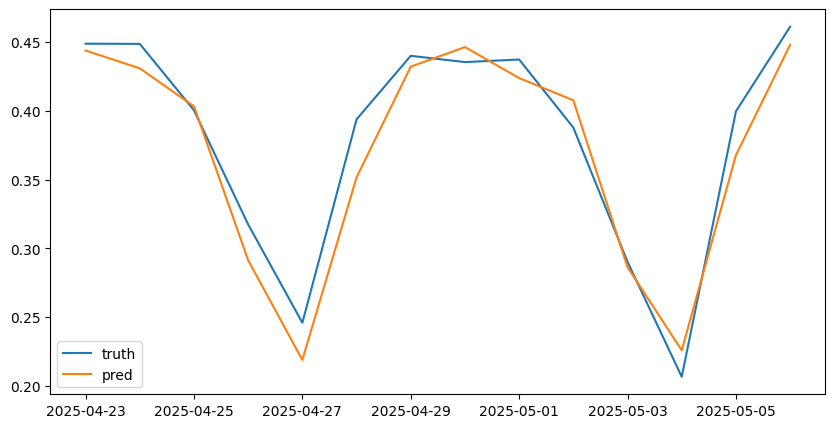

In [51]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(rail_test.iloc[112:112+14],label='truth')
ax.plot(
    pd.Series(
    prediction[-1, -1, :].detach().cpu().numpy(),
    index = rail_test.iloc[112:112+14].index
),label='pred'
)
ax.legend()